# Loads packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.optim as optim
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import sys,os
sys.path.append(os.path.realpath('./src/'))
import pandas as pd
from materialEncoder import MaterialEncoder
import time
import itertools

# Defines functions

In [2]:
def to_np(x):
  return x.detach().cpu().numpy()

def to_torch(x):
  return torch.tensor(x).float()

# Loads the Database

In [36]:
def preprocessData():
  df = pd.read_excel('./data/MaterialDatabase_FULL2.xlsx')# # 
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = np.log10(df[df.columns[3:]].to_numpy())
  dataScaleMax = torch.tensor(np.max(trainInfo, axis = 0))
  dataScaleMin = torch.tensor(np.min(trainInfo, axis = 0))
  normalizedData = (torch.tensor(trainInfo) - dataScaleMin)/(dataScaleMax - dataScaleMin)
  trainingData = torch.tensor(normalizedData).float()
  dataInfo = {'youngsModulus':{'idx':0,'scaleMin':dataScaleMin[0], 'scaleMax':dataScaleMax[0]},\
              'costPerKg':{'idx':1,'scaleMin':dataScaleMin[1], 'scaleMax':dataScaleMax[1]},\
              'massDensity':{'idx':2,'scaleMin':dataScaleMin[2], 'scaleMax':dataScaleMax[2]},\
              'yieldStrength':{'idx':3,'scaleMin':dataScaleMin[3], 'scaleMax':dataScaleMax[3]},\
              'co2Kg':{'idx':4,'scaleMin':dataScaleMin[4], 'scaleMax':dataScaleMax[4]},\
              'energyKg':{'idx':5,'scaleMin':dataScaleMin[5], 'scaleMax':dataScaleMax[5]},\
              'waterKg':{'idx':6,'scaleMin':dataScaleMin[6], 'scaleMax':dataScaleMax[6]}}

  return trainingData, dataInfo, dataIdentifier, trainInfo, df
trainingData, dataInfo, dataIdentifier, trainInfo, df = preprocessData()
numMaterialsInTrainingData, numFeatures = trainingData.shape
props = df.columns[3:].tolist()

C:\Users\luisy\AppData\Local\Temp\ipykernel_9788\2149254349.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainingData = torch.tensor(normalizedData).float()


# Trains the VAE

In [4]:
latentDim, hiddenDim = 2, 250
numEpochs = 50000
epsilon=4.2e-2
epsilon=2e-2
numEpochs = 50000
klFactor = 5e-5
learningRate = 2e-3
savedNet = './data/vaeNet.nt'
vaeSettings = {'encoder':{'inputDim':numFeatures, 'hiddenDim':hiddenDim,\
                                          'latentDim':latentDim},\
               'decoder':{'latentDim':latentDim, 'hiddenDim':hiddenDim,\
                                          'outputDim':numFeatures}}

materialEncoder = MaterialEncoder(trainingData, dataInfo, dataIdentifier, vaeSettings)

start = time.perf_counter()
convgHistory = materialEncoder.trainAutoencoder(numEpochs, klFactor, savedNet, learningRate, epsilon)
print('training time : {:.2F} '.format(time.perf_counter() - start))

Iter 0 reconLoss 4.92E+01 klLoss 5.75E-03 loss 4.93E+01
Iter 500 reconLoss 1.48E+00 klLoss 6.09E-02 loss 1.55E+00
Iter 1000 reconLoss 9.54E-01 klLoss 6.17E-02 loss 1.02E+00
Iter 1500 reconLoss 6.27E-01 klLoss 6.42E-02 loss 6.91E-01
Iter 2000 reconLoss 5.39E-01 klLoss 6.42E-02 loss 6.03E-01
Iter 2500 reconLoss 5.00E-01 klLoss 6.37E-02 loss 5.63E-01
Iter 3000 reconLoss 4.46E-01 klLoss 6.38E-02 loss 5.10E-01
Iter 3500 reconLoss 4.20E-01 klLoss 6.40E-02 loss 4.84E-01
Iter 4000 reconLoss 3.89E-01 klLoss 6.46E-02 loss 4.53E-01
Iter 4500 reconLoss 3.21E-01 klLoss 6.46E-02 loss 3.85E-01
Iter 5000 reconLoss 2.81E-01 klLoss 6.50E-02 loss 3.46E-01
Iter 5500 reconLoss 2.42E-01 klLoss 6.58E-02 loss 3.08E-01
Iter 6000 reconLoss 2.19E-01 klLoss 6.60E-02 loss 2.85E-01
Iter 6500 reconLoss 1.78E-01 klLoss 6.70E-02 loss 2.45E-01
Iter 7000 reconLoss 1.66E-01 klLoss 6.62E-02 loss 2.32E-01
Iter 7500 reconLoss 1.57E-01 klLoss 6.65E-02 loss 2.23E-01
Iter 8000 reconLoss 1.39E-01 klLoss 6.64E-02 loss 2.06E-01
I

# Import the Truss

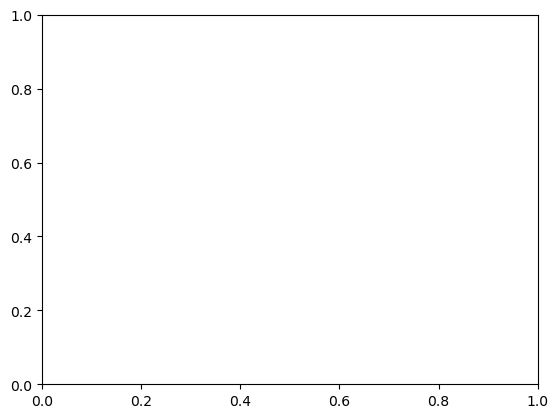

In [37]:
from examples import getExample
from truss3DFE import Truss3DFE

#Loads the example truss
exampleName, nodeXY, connectivity, bc = getExample(19)
#Changes the force
bc['forces'] = {'nodes':np.array([8]), 'fx':1.E3*torch.tensor([0.]), 'fy':1E2*torch.tensor([200.]), 'fz':1E0*torch.tensor([0.])}


n_bars=len(connectivity)



#Loads the truss in truss
truss = Truss3DFE(nodeXY, connectivity, bc)

# Gets the z coordinates of each material

In [38]:
vae = materialEncoder.vaeNet
#In decoded there are the decoded properties of each material
#decoded = vae.decoder(vae.encoder.z)
#In z_np are the coordinates of each real material in the latent space
z_np = to_np(vae.encoder.z)
#I get the minimum and maximum z to restrict my boundaries of latent space
z0min, z1min = 0.95*np.min(z_np, axis=0)
z0max, z1max = 1.05*np.max(z_np, axis=0)

nprops=len(props)
max_scale = np.empty(nprops)
min_scale = np.empty(nprops)

#Gets minimum and maximum of each property
for p in props:
    idx = materialEncoder.dataInfo[p]['idx']
    max_scale[idx] = materialEncoder.dataInfo[p]['scaleMax']
    min_scale[idx] = materialEncoder.dataInfo[p]['scaleMin']

# Defines objective and constraints

In [39]:
#Defines constraints and objectives
constraints = {'massCons': {'isOn':False, 'maxMass':5}, \
               'costCons': {'isOn':False, 'maxCost':5},\
               'tensionCons': {'isOn':True, 'FOS':4.},\
               'complianceCons': {'isOn':False, 'maxJ':35},\
               'compressionCons': {'isOn':True, 'FOS':4.},\
               'co2Cons': {'isOn':False, 'maxco2':30},\
               'energyCons': {'isOn':False, 'maxenergy' : 1e10},\
               'waterCons': {'isOn':False, 'maxwater':4e3},\
               'confidenceCons': {'isOn':True, 'minconf':93}}


objectives = {'cost': {'isOn':False},\
              'mass': {'isOn':False}, \
              'co2': {'isOn':True},\
              'water': {'isOn':True},\
              'energy': {'isOn':True},\
              'compliance': {'isOn': False}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Two or more entries have isOn=True')

Error: Two or more entries have isOn=True


# Defines the problem

In [40]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self, truss, z_np, constraints, objectives, no, nc, n_bars):
        super().__init__(n_var=n_bars+2,
                         n_obj=no,
                         n_ieq_constr=nc,
                         xl = np.array([z0min, z1min] + [1e-7] * (n_bars)),
                         xu = np.array([z0max, z1max] + [1e-3] * (n_bars)))

        

        self.truss=truss
        self.z_np=z_np
        self.constraints=constraints
        self.objectives=objectives


    def _evaluate(self, x, out, *args, **kwargs):

        Z = torch.zeros((1, vaeSettings['encoder']['latentDim']))
        Z[:,0]=x[0]
        Z[:,1]=x[1]

        
        matprop=np.empty(7)
        #Decodes the properties of Z
        decoded = vae.decoder(Z)
        #Scales properties
        for i in range(0,nprops): 
            matprop[i] = 10.**(min_scale[i] + decoded[:,i]*(max_scale[i] - min_scale[i]))
        
        x_tensor = torch.from_numpy(x[2:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _,_, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6]


        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        if(constraints['confidenceCons']['isOn']):
            zData=x[0:2]
            dist= np.linalg.norm(zData- z_np, axis = 1)
            maxDist = np.max(dist)
            distOrder = np.argsort(dist)
            confidence_level = 100.*(1.- (dist[distOrder[0]]/maxDist))
            constraints['confidenceCons']['value'] = 1 - (confidence_level/constraints['confidenceCons']['minconf'])
            con_values.append(constraints['confidenceCons']['value'])        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
            


        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)        
        

problem = MyProblem(truss, z_np, constraints, objectives, no, nc, n_bars)

# Defines the problem settings

In [47]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling

#pop_size: Size of initial population
#n_offsprings: The number of offspring generated in each generation of the algorithm. 
#sampling: The sampling method used to generate new individuals in the offspring population.
    #In this case, FloatRandomSampling is used, which generates random floating-point values
    #in the search space to create new individuals.
#crossover: The crossover operator used to create new individuals in the offspring population.
#mutation: The mutation operator used to create new individuals in the offspring population.
#eliminate_duplicates: A flag to indicate whether duplicate individuals should be eliminated from the population or not.
algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination

#termination = get_termination("n_gen", 150)

termination = DefaultMultiObjectiveTermination(
    xtol=1e-2,
    cvtol=1e-3,
    ftol=0.1,
    period=10,
    n_max_gen=1500,
    n_max_evals=50000
)

# Runs the solver

In [48]:
from pymoo.optimize import minimize
start = time.perf_counter()
res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

print('training time : {:.2F} '.format(time.perf_counter() - start))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       40 |      1 |  0.2556228351 |  3.824581E+02 |             - |             -
     2 |       50 |      1 |  0.0839596387 |  3.010366E+01 |             - |             -
     3 |       60 |      1 |  0.0839596387 |  8.4349477045 |             - |             -
     4 |       70 |      1 |  0.0839596387 |  4.3318349263 |             - |             -
     5 |       80 |      1 |  0.0839596387 |  2.6378035495 |             - |             -
     6 |       90 |      1 |  0.000000E+00 |  1.8689129771 |             - |             -
     7 |      100 |      1 |  0.000000E+00 |  1.3550173352 |  0.000000E+00 |             f
     8 |      110 |      1 |  0.000000E+00 |  0.9084488661 |  0.000000E+00 |             f
     9 |      120 |      1 |  0.000000E+00 |  0.5176302737 |  0.000000E+00 |             f
    10 |      130 |      1 |  0.000000E+00 |  0.1996120364 |  0.000000E+00 |             f

    91 |      940 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0054724629 |             f
    92 |      950 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0156025861 |         ideal
    93 |      960 |      8 |  0.000000E+00 |  0.000000E+00 |  0.0331356230 |         ideal
    94 |      970 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0140939175 |             f
    95 |      980 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0036820887 |         ideal
    96 |      990 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0344708993 |         ideal
    97 |     1000 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0119019252 |             f
    98 |     1010 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0440516255 |         ideal
    99 |     1020 |     12 |  0.000000E+00 |  0.000000E+00 |  0.0149257151 |         ideal
   100 |     1030 |     13 |  0.000000E+00 |  0.000000E+00 |  0.0435132975 |         nadir
   101 |     1040 |     11 |  0.000000E+00 |  0.000000E+00 |  0.0524339331 |         ideal

   184 |     1870 |     17 |  0.000000E+00 |  0.000000E+00 |  0.0134364356 |             f
   185 |     1880 |     17 |  0.000000E+00 |  0.000000E+00 |  0.0525656042 |         ideal
   186 |     1890 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0047879539 |             f
   187 |     1900 |     15 |  0.000000E+00 |  0.000000E+00 |  0.0351592646 |         ideal
   188 |     1910 |     16 |  0.000000E+00 |  0.000000E+00 |  0.0079814954 |         ideal
   189 |     1920 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0315026781 |         ideal
   190 |     1930 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0097476717 |             f
   191 |     1940 |     19 |  0.000000E+00 |  0.000000E+00 |  0.0948075900 |         ideal
   192 |     1950 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0115234756 |             f
   193 |     1960 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0175240088 |         nadir
   194 |     1970 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0100567906 |             f

   277 |     2800 |     18 |  0.000000E+00 |  0.000000E+00 |  0.0089951776 |         nadir
   278 |     2810 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0069777995 |             f
   279 |     2820 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0538335112 |         ideal
   280 |     2830 |     21 |  0.000000E+00 |  0.000000E+00 |  0.2204617490 |         nadir
   281 |     2840 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0035658648 |             f
   282 |     2850 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0100433308 |             f
   283 |     2860 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0029329064 |             f
   284 |     2870 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0109291811 |             f
   285 |     2880 |     25 |  0.000000E+00 |  0.000000E+00 |  0.0024836934 |             f
   286 |     2890 |     26 |  0.000000E+00 |  0.000000E+00 |  0.0236142037 |         nadir
   287 |     2900 |     24 |  0.000000E+00 |  0.000000E+00 |  0.0072548158 |             f

['AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm', 'AISI 4340 norm']


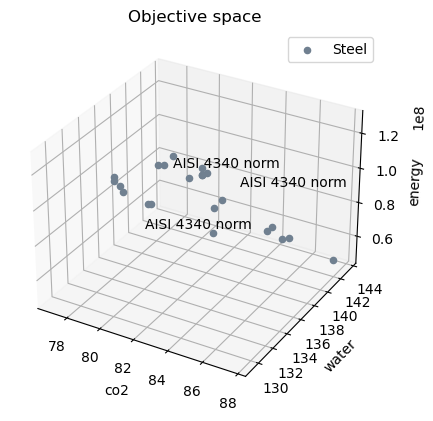

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
X = res.X
F = res.F
G = res.G


Z_res=X[:,0:2]




names = []
types = []

legend_dict = {}


for zData in Z_res:
    dist = np.linalg.norm(zData - z_np, axis=1)
    meanDist = np.max(dist)
    distOrder = np.argsort(dist)
    matname = dataIdentifier['name'][distOrder[0]]
    mattype = dataIdentifier['className'][distOrder[0]]
    names.append(matname)
    types.append(mattype)

unique_labels = list(set(types))



# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}


print(names)        



# 3D Scatter Plot
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# add scatter plot for each unique label
for i, (x, y, z) in enumerate(F):
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    ax3d.scatter(x, y, z, color=color, label=label)
    #ax3d.text(x + 0.1, y + 0.1, z + 0.1, material)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax3d.scatter(x, y, z, color=color, label=label)

   

ax3d.text(80, 138, 1e8, material)
ax3d.text(84, 138, 1e8, material)
ax3d.text(82, 130, 1e8, material)


# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")


# show plot

entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]





ax3d.legend(handles, labels, loc="upper right")
ax3d.set_xlabel(enabled_entries[0])
ax3d.set_ylabel(enabled_entries[1])
ax3d.set_zlabel(enabled_entries[2])
ax3d.set_title("Objective space")

plt.savefig('./figures_Advanced/Preliminary_Pareto.png', bbox_inches='tight', dpi=200)
plt.show()

# Re-runs a solver with real materials

In [53]:
# Reduces the database to the groups imvolved
candidate_types1 = list(set(types))

mask = df['class'].isin(candidate_types1)

# Filter the DataFrame using the mask
df2 = df[mask]
df2 = df2.reset_index(drop=True)

dataIdentifier2 = {'name': df2[df2.columns[0]], 'className':df2[df2.columns[1]], 'classID':df2[df2.columns[2]]} # name of the material and type
trainInfo2 = torch.tensor((df2[df2.columns[3:]].to_numpy())).float()


props = df2.columns[3:].tolist()
nmat, nprop = trainInfo2.size()

In [55]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.termination.default import DefaultMultiObjectiveTermination

class MixedVarsZDT1(ElementwiseProblem):

    def __init__(self, truss, trainInfo2 , constraints, objectives, nc, no, nmat, n_bars, **kwargs):

        variables = dict()

        variables[f"x01"] = Integer(bounds=(0, nmat-1))

        for k in range(2, n_bars+2):
            variables[f"x{k:02}"] = Real(bounds=(1e-7, 1e-3))

        super().__init__(vars=variables, n_obj=no, n_ieq_constr=nc, **kwargs)
        
        self.truss=truss
        self.trainInfo2=trainInfo2
        self.constraints=constraints
        self.objectives=objectives
        
    def _evaluate(self, x, out, *args, **kwargs):
        x = np.array([x[f"x{k:02}"] for k in range(1, n_bars+2)])
        
        matprop=trainInfo2[int(x[0]),:]  
        
        x_tensor = torch.from_numpy(x[1:])
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 

        
        
        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)
  
            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)

if(constraints['confidenceCons']['isOn']):
    ncons=nc-1
else:
    ncons=nc

  

problem2 = MixedVarsZDT1(truss, trainInfo2, constraints, objectives, ncons, no, nmat, n_bars)

    
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

algorithm = NSGA2(pop_size=50,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),
                  )

termination=('n_gen', 150)


In [56]:
start = time.perf_counter()
res = minimize(problem2,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
print('Solver time : {:.2F}'.format(time.perf_counter() - start))

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       50 |      1 |  0.000000E+00 |  1.508056E+02 |             - |             -
     2 |      100 |      1 |  0.000000E+00 |  5.2720013027 |  1.201983E+09 |         ideal
     3 |      150 |      2 |  0.000000E+00 |  1.4973712788 |  1.0000000000 |         ideal
     4 |      200 |      2 |  0.000000E+00 |  0.5757362925 |  0.000000E+00 |             f
     5 |      250 |      3 |  0.000000E+00 |  0.1334441186 |  0.0447491139 |         ideal
     6 |      300 |      4 |  0.000000E+00 |  0.000000E+00 |  0.2924113619 |         ideal
     7 |      350 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0114699190 |         ideal
     8 |      400 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0264182105 |         ideal
     9 |      450 |      5 |  0.000000E+00 |  0.000000E+00 |  0.0698369773 |         ideal
    10 |      500 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0083654497 |         ideal

    90 |     4500 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0012076904 |             f
    91 |     4550 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0012076904 |             f
    92 |     4600 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0082149432 |         nadir
    93 |     4650 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0006460483 |             f
    94 |     4700 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0111454858 |         nadir
    95 |     4750 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0032930379 |             f
    96 |     4800 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0004656597 |             f
    97 |     4850 |      4 |  0.000000E+00 |  0.000000E+00 |  0.0025770013 |         nadir
    98 |     4900 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
    99 |     4950 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
   100 |     5000 |      4 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f

['AISI 4340 norm', 'AISI 1045 CD', 'Cast Carbon St', 'AISI 1010']


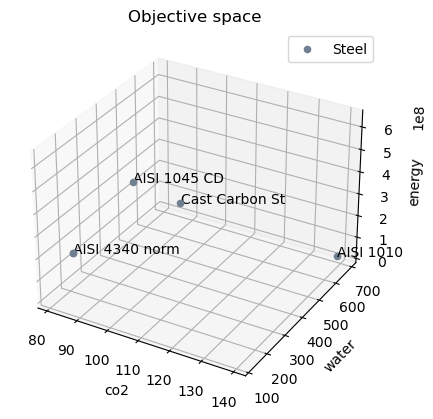

In [57]:
X = res.X
F = res.F
G = res.G
Z_res = [[d['x01']] for d in X]



legend_dict = {}


names = []
types = []

for xData in Z_res:
    matname = dataIdentifier2['name'][int(xData[0])]
    mattype = dataIdentifier2['className'][int(xData[0])]
    names.append(matname)
    types.append(mattype)
    
unique_labels = list(set(types))



# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}


print(names)        



# 3D Scatter Plot
fig = plt.figure()
ax3d = fig.add_subplot(111, projection='3d')

# add scatter plot for each unique label
for i, (x, y, z) in enumerate(F):
    material = names[i]
    mattype = types[i]
    color = mat_colors[mattype]
    label = mattype
    ax3d.scatter(x, y, z, color=color, label=label)
    ax3d.text(x + 0.1, y + 0.1, z + 0.1, material)
    if mattype not in legend_dict:
        legend_dict[mattype] = ax3d.scatter(x, y, z, color=color, label=label)




# set legend colors and remove duplicates
handles, labels = [], []
for label in legend_dict:
    handles.append(legend_dict[label])
    labels.append(label)
    legend_dict[label].set_color(mat_colors[label])
    
ax.legend(handles, labels, loc="upper right")


# show plot

entry_order = ['cost', 'mass', 'co2', 'water', 'energy', 'compliance']
enabled_entries = [entry for entry in entry_order if objectives[entry]['isOn']]





ax3d.legend(handles, labels, loc="upper right")
ax3d.set_xlabel(enabled_entries[0])
ax3d.set_ylabel(enabled_entries[1])
ax3d.set_zlabel(enabled_entries[2])
ax3d.set_title("Objective space")

plt.savefig('./figures_Advanced/Final_Pareto.png', bbox_inches='tight', dpi=200)
plt.show()


[ 81.16668394 106.59546754]
[200.14948893 124.94711156]


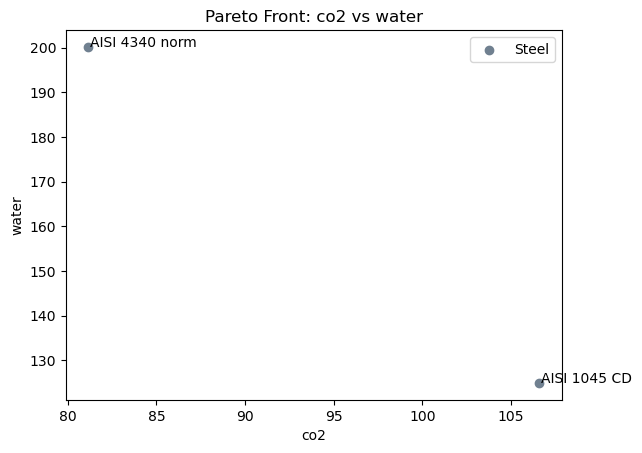

In [58]:
# Scatter Plot for X and Y
# Find Pareto front
num_points = F.shape[0]
pareto_front = []

for i in range(num_points):
    is_pareto = True
    for j in range(num_points):
        if F[j, 0] < F[i, 0] and F[j, 1] < F[i, 1]:
            is_pareto = False
            break
    if is_pareto:
        pareto_front.append(i)


fig, ax = plt.subplots()
pareto_front_x = F[pareto_front, 0]
pareto_front_y = F[pareto_front, 1]

print(pareto_front_x)
print(pareto_front_y)

scatter_points = []
for i, (x, y) in enumerate(zip(pareto_front_x, pareto_front_y)):
    material = names[pareto_front[i]]
    mattype = types[pareto_front[i]]
    color = mat_colors[mattype]
    label = mattype
    scatter = ax.scatter(x, y, color=color, label=label)
    ax.text(x + 0.1, y + 0.1, material)
    scatter_points.append(scatter)

# Create legend handles and labels for displayed points only
handles, labels = [], []
for scatter in scatter_points:
    if scatter.get_label() not in labels:
        handles.append(scatter)
        labels.append(scatter.get_label())

ax.legend(handles, labels, loc="upper right")
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
ax.set_title("Pareto Front: " + str(enabled_entries[0]) + " vs " + str(enabled_entries[1]))

plt.savefig('./figures/Scatter_Plot_X_vs_Y.png', bbox_inches='tight', dpi=200)
plt.show()

[ 81.16668394 139.41588711]
[1.60352338e+08 2.39487112e+07]


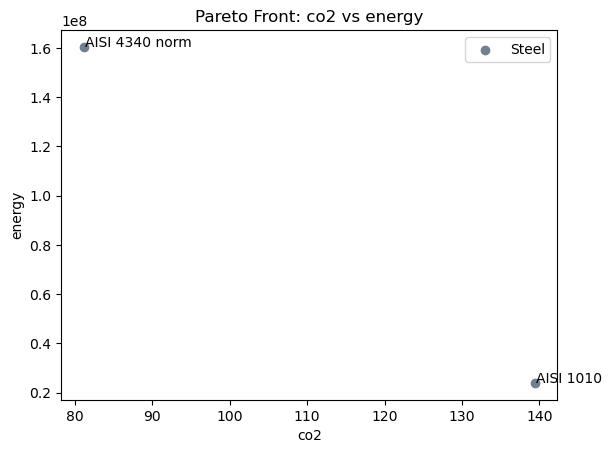

In [59]:
# Scatter Plot for X and Z
# Find Pareto front
num_points = F.shape[0]
pareto_front = []

for i in range(num_points):
    is_pareto = True
    for j in range(num_points):
        if F[j, 0] < F[i, 0] and F[j, 2] < F[i, 2]:
            is_pareto = False
            break
    if is_pareto:
        pareto_front.append(i)


fig, ax = plt.subplots()
pareto_front_x = F[pareto_front, 0]
pareto_front_y = F[pareto_front, 2]

print(pareto_front_x)
print(pareto_front_y)

scatter_points = []
for i, (x, y) in enumerate(zip(pareto_front_x, pareto_front_y)):
    material = names[pareto_front[i]]
    mattype = types[pareto_front[i]]
    color = mat_colors[mattype]
    label = mattype
    scatter = ax.scatter(x, y, color=color, label=label)
    ax.text(x + 0.1, y + 0.1, material)
    scatter_points.append(scatter)

# Create legend handles and labels for displayed points only
handles, labels = [], []
for scatter in scatter_points:
    if scatter.get_label() not in labels:
        handles.append(scatter)
        labels.append(scatter.get_label())

ax.legend(handles, labels, loc="upper right")
ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[2])
ax.set_title("Pareto Front: " + str(enabled_entries[0]) + " vs " + str(enabled_entries[2]))

plt.savefig('./figures/Scatter_Plot_X_vs_Z.png', bbox_inches='tight', dpi=200)
plt.show()

[200.14948893 124.94711156 188.11008366 685.02291616]
[1.60352338e+08 6.29960324e+08 5.38261758e+08 2.39487112e+07]


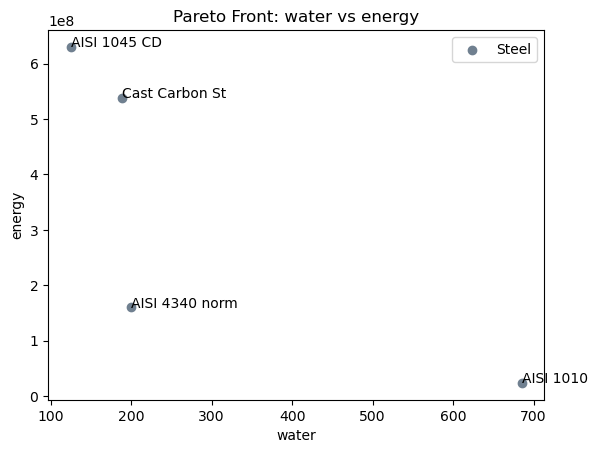

In [60]:
# Scatter Plot for Y and Z
# Find Pareto front
num_points = F.shape[0]
pareto_front = []

for i in range(num_points):
    is_pareto = True
    for j in range(num_points):
        if F[j, 1] < F[i, 1] and F[j, 2] < F[i, 2]:
            is_pareto = False
            break
    if is_pareto:
        pareto_front.append(i)


fig, ax = plt.subplots()
pareto_front_x = F[pareto_front, 1]
pareto_front_y = F[pareto_front, 2]

print(pareto_front_x)
print(pareto_front_y)

scatter_points = []
for i, (x, y) in enumerate(zip(pareto_front_x, pareto_front_y)):
    material = names[pareto_front[i]]
    mattype = types[pareto_front[i]]
    color = mat_colors[mattype]
    label = mattype
    scatter = ax.scatter(x, y, color=color, label=label)
    ax.text(x + 0.1, y + 0.1, material)
    scatter_points.append(scatter)

# Create legend handles and labels for displayed points only
handles, labels = [], []
for scatter in scatter_points:
    if scatter.get_label() not in labels:
        handles.append(scatter)
        labels.append(scatter.get_label())

ax.legend(handles, labels, loc="upper right")
ax.set_xlabel(enabled_entries[1])
ax.set_ylabel(enabled_entries[2])
ax.set_title("Pareto Front: " + str(enabled_entries[1]) + " vs " + str(enabled_entries[2]))

plt.savefig('./figures/Scatter_Plot_Y_vs_Z.png', bbox_inches='tight', dpi=200)
plt.show()